<a href="https://colab.research.google.com/github/haimin777/tools/blob/master/TrainDetectorLabMeDataSynData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow==2.3.0
!pip install -U git+https://github.com/haimin777/keras-ocr.git
!pip install -U opencv-python # We need the most recent version of OpenCV.

!pip install tensorflow-addons==0.11.2

%tensorflow_version 2.x

from IPython.display import clear_output
clear_output()

In [3]:
import zipfile
import datetime
import string
import glob
import math
import os
import shutil as sh

import typing
import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import tensorflow as tf
import sklearn.model_selection

from tensorflow import keras
import keras_ocr
import numpy as np
import pandas as pd
import imgaug

from xml.etree import ElementTree
from xml.etree.ElementTree import XMLParser
from numpy import array

import cv2

os.chdir('/content/drive/My Drive/AIgym/keras-ocr')
#!git clone https://github.com/debidatta/syndata-generation.git
#%tensorflow_version 1.x
!ls | grep zip

backgrounds.zip
croppedSuits.zip
datasetVin_fonts_27_1k_small_big.zip
datasetVin_fonts_27_1k_webp_noise_small_big_3.zip
datasetVin_fonts_27_1k_webp_noise_small_big.zip
datasetVin_fonts_27_262_small_big.zip
datasetVin_fonts_27_262_small.zip
datasetVin_fonts_27_5k_small_big_1.zip
datasetVin_fonts_27_5k_small_big_2.zip
datasetVin_fonts_300_262_small_1.zip
datasetVin_fonts_300_262_small_big.zip
datasetVin_fonts_300_5k_small_1.zip
datasetVin_fonts_300_5k_small_2.zip
fonts.zip
GG_groundTrue_Train.zip
GGPokerOk_GT_3_cat.zip
GG_TrainDataset_cards_2+1_1.zip
GG_TrainDataset_cards_2+1_2.zip
GroundTRue_3categories.zip
grpc_ocr_docker.zip
round_rectangles.zip


In [4]:
!unzip -q -o datasetVin_fonts_27_1k_webp_noise_small_big_3.zip


In [5]:
# Download data
if not os.path.exists('GG_TrainDataset_cards_2+1_1'):
     print('https://docs.google.com/uc?export=download&id=1Ar_gigt1B4uBGx5S3gsnPxn2UJu5HB8G', 'download and unzip')


In [ ]:
# dataset with labeled images:

dataset_dir = 'GG_TrainDataset_cards_2+1_1'

jpg_paths = glob.glob(dataset_dir + '/*webp')
xml_paths = glob.glob(dataset_dir + '/*xml')
jpg_paths.sort()
xml_paths.sort()
dataset = keras_ocr.datasets.get_lableme_detector_dataset(jpg_paths, xml_paths)
len(dataset)

262

In [6]:
def get_dataset(dirs_list):

    # create dataset from generated img + txt data

    dataset = []
    for directory in dirs_list:
        dataset += keras_ocr.datasets.get_DigitDataset_detector_dataset(directory, skip_illegible=True)

        print(len(dataset))           
    return dataset

In [7]:
datasset = []
dirs_list = [ 'datasetVin_fonts_27_1k_webp_noise_small_big_3',
             ]

#dataset += get_dataset(dirs_list)
dataset = get_dataset(dirs_list)

len(dataset)


1000


1000

In [8]:
train, validation = sklearn.model_selection.train_test_split(
    dataset, train_size=0.8, random_state=42)


In [9]:
generator_kwargs = {'width': 640, 'height': 640}
#generator_kwargs = {'width': 320, 'height': 640}

augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.Affine(
    scale=(0.8, 1.3),
    #rotate=(-5, 5)
    ),
    imgaug.augmenters.GaussianBlur(sigma=(0, 0.5)),
        imgaug.augmenters.ChannelShuffle(0.5),

    #imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2)
])

training_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=train,    
    #augmenter=augmenter,
    **generator_kwargs
)
validation_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=validation,
    **generator_kwargs
)

image_generators = [training_image_generator, validation_image_generator]

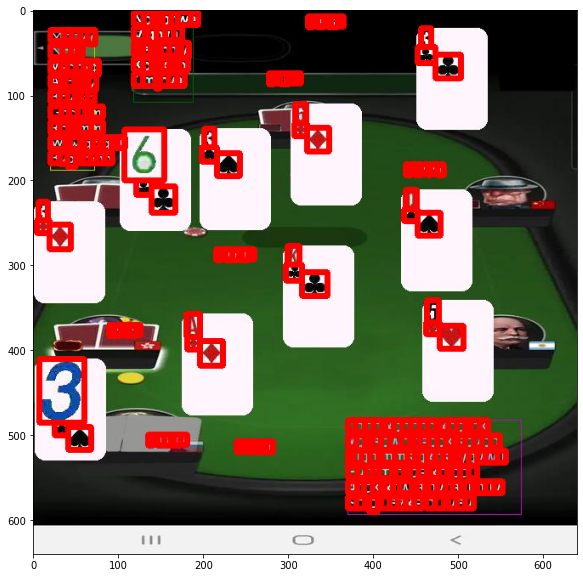

In [10]:
image, lines, confidence = next(training_image_generator)
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.figure(figsize=(10,10))

plt.imshow(canvas)

In [12]:
!cp '/content/drive/My Drive/AIgym/keras-ocr/craft_mlt_25k.h5' '/root/.keras-ocr/craft_mlt_25k.h5'
!cp '/content/drive/My Drive/AIgym/keras-ocr/crnn_kurapan_notop.h5' '/root/.keras-ocr/crnn_kurapan_notop.h5'
!cp '/content/drive/My Drive/AIgym/keras-ocr/crnn_kurapan.h5' '/root/.keras-ocr/crnn_kurapan.h5'

In [13]:
import tensorflow.keras.optimizers as opts

adam_opt = opts.Adam(learning_rate=0.0001)
detector = keras_ocr.detection.Detector(weights='clovaai_general', optimizer=adam_opt)
#detector = keras_ocr.detection.Detector()
#detector.model.load_weights(detect_weights[-1])
#for layer in detector.model.layers[:41]:
    #layer.trainable=False
#detector.model.compile(loss='mse', optimizer=adam_opt)

Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [15]:

batch_size = 8
data_dir = '/content/drive/My Drive/AIgym/keras-ocr/trained_weights'
#detector_basepath = os.path.join(data_dir, f'det_DatasetVin_Exper_H_colab{datetime.datetime.now().isoformat()}_ep_{epoch:02d}')
detector_basepath = os.path.join(data_dir, f'det_DatasetVin_Exper_H_colab{datetime.datetime.now().isoformat()}')

training_generator, validation_generator = [
    detector.get_batch_generator(
        image_generator=image_generator, batch_size=batch_size
    ) for image_generator in
    [training_image_generator, validation_image_generator]
]
detector.model.fit_generator(
    generator=training_generator,
    steps_per_epoch=math.ceil(len(train) / batch_size),
    epochs=1,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=False, patience=5, verbose=1),
        tf.keras.callbacks.CSVLogger((f'{detector_basepath}.csv')),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5',
                                           save_best_only=True,
                                           verbose=1)
    ],
    validation_data=validation_generator,
    validation_steps=math.ceil(len(validation) / batch_size)
)

100/100 [==============================] - ETA: 0s - loss: 0.0026
Epoch 00001: val_loss improved from inf to 0.00251, saving model to /content/drive/My Drive/AIgym/keras-ocr/trained_weights/det_DatasetVin_Exper_H_colab2021-01-15T13:43:33.511196.h5
100/100 [==============================] - 1085s 11s/step - loss: 0.0026 - val_loss: 0.0025


In [16]:
keras.__version__

'2.4.0'